## Adult income

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


%matplotlib inline

# 1. Data preprocessing

In [2]:
df = pd.read_hdf('../input/train.adult.h5')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [4]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K


In [5]:
df.describe(include='all')

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
count,32561.000000,30725,3.256100e+04,32561,32561.000000,32561,30718,32561,32561,32561,32561.000000,32561.000000,32561.000000,31978,32561
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,True,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,423.516600,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,3363.342471,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,-31441.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


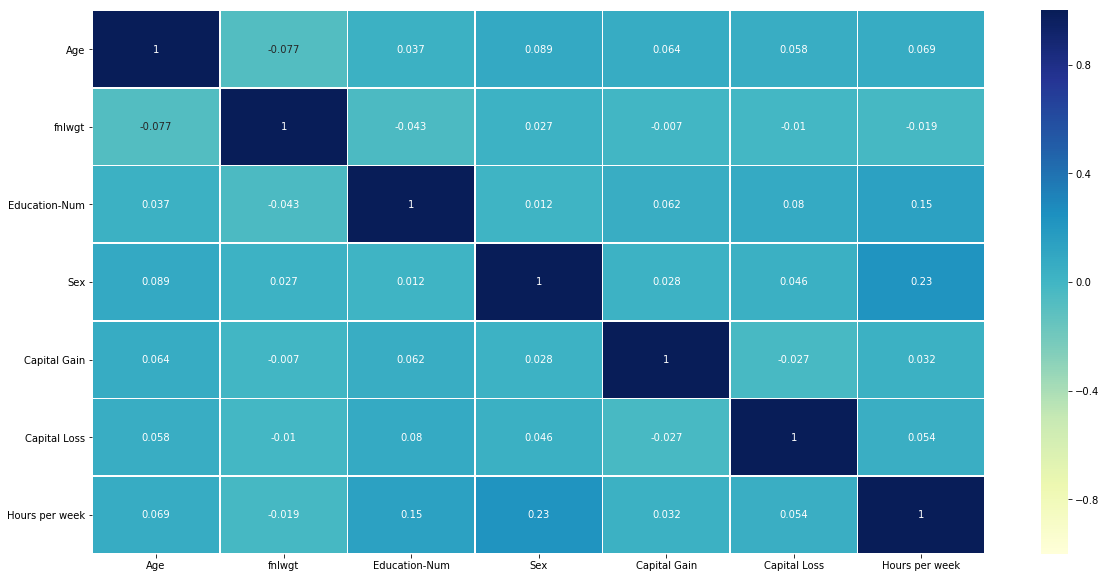

In [6]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [7]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('Workclass', 1836)
('Occupation', 1843)
('Country', 583)


In [8]:
df = df.fillna(-1)
check_missing()

# 2. Label encoding

In [9]:
cat_feats = df.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

df['Sex_cat'] = df['Sex'].map(lambda x: int(x=True))
    
train = df.select_dtypes(include=[np.int8, np.int16, np.int64])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age                   32561 non-null int8
fnlwgt                32561 non-null int64
Education-Num         32561 non-null int64
Capital Gain          32561 non-null int16
Capital Loss          32561 non-null int16
Hours per week        32561 non-null int8
Workclass_cat         32561 non-null int64
Education_cat         32561 non-null int64
Martial Status_cat    32561 non-null int64
Occupation_cat        32561 non-null int64
Relationship_cat      32561 non-null int64
Race_cat              32561 non-null int64
Country_cat           32561 non-null int64
Target_cat            32561 non-null int64
Sex_cat               32561 non-null int64
dtypes: int16(2), int64(11), int8(2)
memory usage: 3.2 MB


# 3. Feature engeenering

In [10]:
feats = train.columns.values
feats = list(feats)
feats.remove('Target_cat')
feats.remove('Education_cat')
feats = np.array(feats)
feats

array(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_cat', 'Martial Status_cat',
       'Occupation_cat', 'Relationship_cat', 'Race_cat', 'Country_cat',
       'Sex_cat'],
      dtype='<U18')

# 4. Train and predict

In [11]:
def train_and_predict(model, X_train, y_train, X_test, y_test, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return success_metric(y_test, y_pred)

models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10),
    ExtraTreesClassifier(max_depth=10)
]

In [12]:
X = train[feats]
y = train['Target_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
scores = []
for model in models:
    score = train_and_predict(model, X_train, y_train, X_test, y_test)
    scores.append((score, model))
scores

[(0.78421537516634254,
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 (0.85576824649401162,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 (0.85689425734466174,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=10, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_

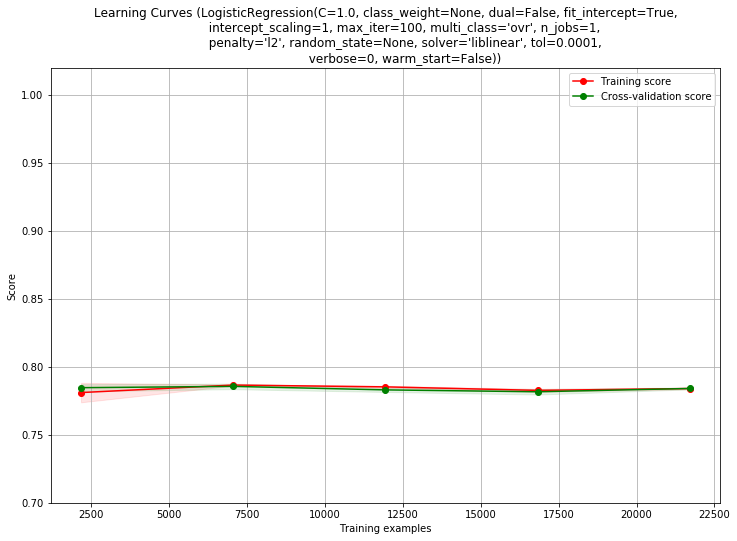

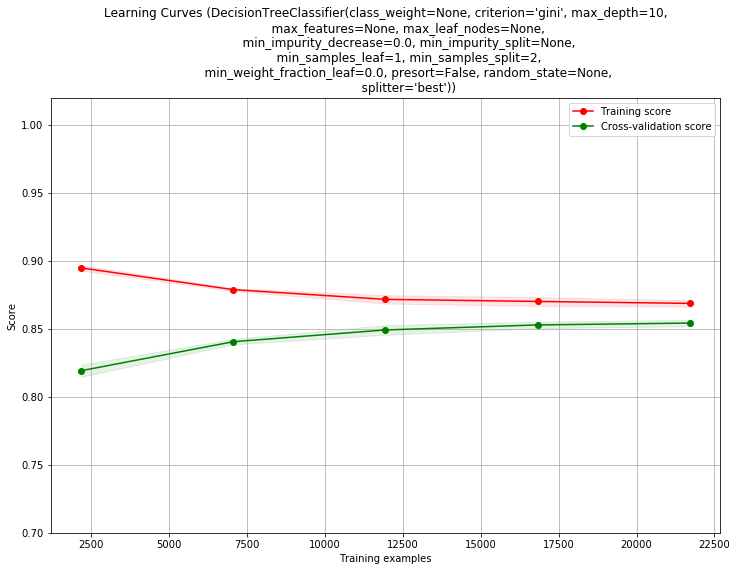

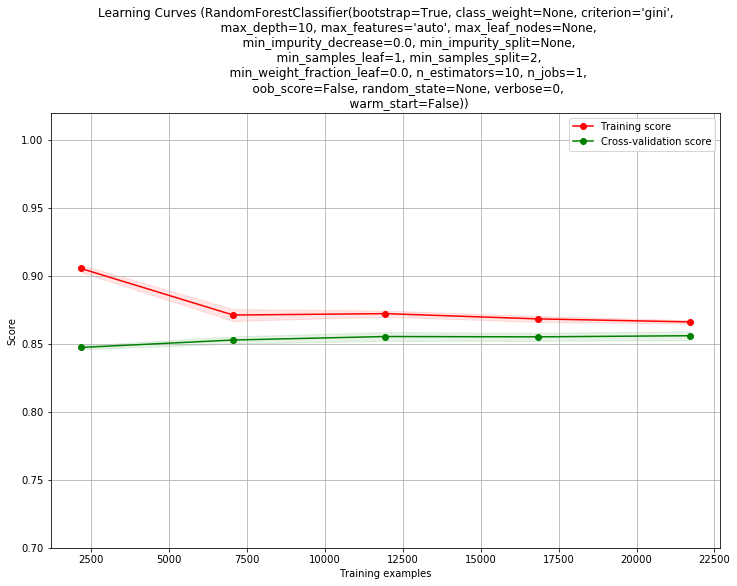

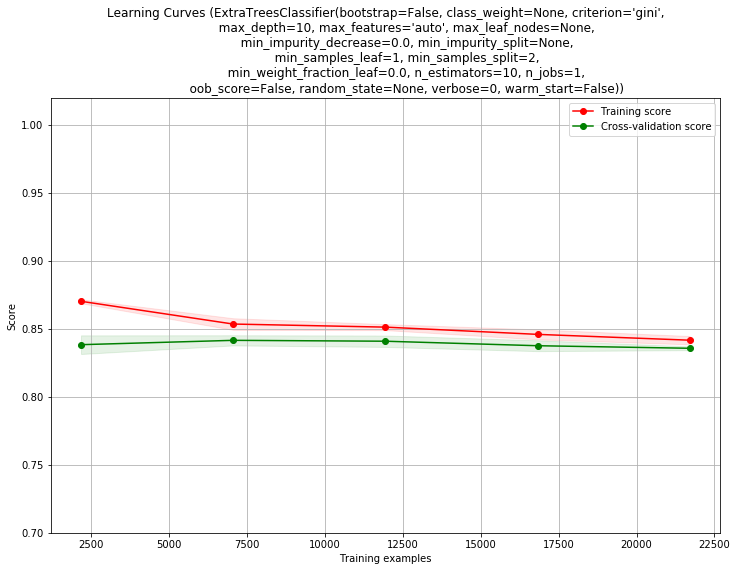

In [14]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

for model in models:
    plt = plot_learning_curve(model, "Learning Curves ({})".format(model), X, y, ylim=(0.7, 1.02), cv=3, n_jobs=4)
    plt.show()

In [15]:
train = train[train['Capital Gain'] > 0]

X = train[feats].values
y = train['Target_cat'].values

scores = []
for n_splits in range(2,15):
    kf = KFold(n_splits=n_splits)
    acc_score = []
    for train_indice, test_indice in kf.split(X, y):
        X_train, X_test, y_train, y_test = X[train_indice], X[test_indice], y[train_indice], y[test_indice]
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_score.append(accuracy_score(y_test, y_pred))
    
    score = np.mean(acc_score)
    print('n_splits:', (n_splits), ',', 'score:', (score))
    scores.append(score)

print(('best is n_splits {0}:'.format(scores.index(max(scores))+2)), max(scores))

n_splits: 2 , score: 0.941869599372
n_splits: 3 , score: 0.952870932136
n_splits: 4 , score: 0.951686117117
n_splits: 5 , score: 0.942658037675
n_splits: 6 , score: 0.951693488716
n_splits: 7 , score: 0.946982671009
n_splits: 8 , score: 0.951682981408
n_splits: 9 , score: 0.950112355796
n_splits: 10 , score: 0.950520302609
n_splits: 11 , score: 0.954046736962
n_splits: 12 , score: 0.950115525438
n_splits: 13 , score: 0.95051523568
n_splits: 14 , score: 0.952088952878
best is n_splits 11: 0.954046736962
